In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import pandas as pd
from PIL import Image
import os
import pydicom as dicom

# Dataset extraction

In [11]:
targets = []
features = []

folder_path = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean"

files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file) # join the folder_path and the file name to get the file_path
    img = dicom.read_file(file_path) #read dicom image
    img_array = img.pixel_array #get image array
    img_from_array = Image.fromarray(img_array) #convert array to PIL.Image
    img_resize = img_from_array.resize((75,75),resample=Image.NEAREST) #resize the image
    img_resize_array = np.asarray(img_resize) #convert PIL.Image to np.array
    
    data_table = pd.read_excel('D:\DataSet\CCMD_BreastCancer\CMMD_clinicaldata_revision.xlsx', index_col=0, engine='openpyxl')
    
    side = img.ImageLaterality
    fileId = file[0:7]
    
    if ((data_table.index == fileId).sum()) != 0: #check if the fileId is in the data_table
        
        # check if there is data for the corresponding breast side of the picture
        if (data_table[(data_table['LeftRight']==side) & (data_table.index==fileId)].index.value_counts().values) > 0:
            features.append(img_resize_array) #append the np.array to features
            
            if data_table.query('id==@fileId & LeftRight==@side')['classification'].item() == 'Benign':
                target = [0,1]
                targets.append(target)

            elif data_table.query('id==@fileId & LeftRight==@side')['classification'].item() == 'Malignant':
                target = [1,0]
                targets.append(target)
    
    
features = np.array(features)
targets = np.array(targets)
print("Features shape :", features.shape)
print("Targets shape :", targets.shape)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Features shape : (3744, 75, 75)
Targets shape : (3744, 2)


# Test / Validation dataset split 

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.1, random_state=42)

X_train = np.expand_dims(X_train, -1) # features need to have a matrice size(x,x,x,1)
X_valid = np.expand_dims(X_valid, -1)

print("X_train", X_train.shape)
print("X_valid", X_valid.shape)
print("y_train", y_train.shape)
print("y_valid", y_valid.shape)

X_train (3369, 75, 75, 1)
X_valid (375, 75, 75, 1)
y_train (3369, 2)
y_valid (375, 2)


# Model creation

In [13]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image

model = models.Sequential()

model.add(layers.Conv2D(32, 3, input_shape=(75,75,1), name="conv_layer1"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, 3, name="conv_layer2"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, 3, name="conv_layer3"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, name="conv_layer4"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 73, 73, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 36, 36, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 36, 36, 32)        0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 17, 17, 64)       

# Model Fit

In [14]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_valid, y_valid))

Train on 3369 samples, validate on 375 samples
Epoch 1/10
3369/3369 [==============================] - 11s 3ms/sample - loss: 0.6509 - accuracy: 0.7026 - val_loss: 0.6671 - val_accuracy: 0.6693
Epoch 2/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6498 - accuracy: 0.7067 - val_loss: 0.6638 - val_accuracy: 0.6693
Epoch 3/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6507 - accuracy: 0.7029 - val_loss: 0.6686 - val_accuracy: 0.6693
Epoch 4/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6498 - accuracy: 0.7067 - val_loss: 0.6686 - val_accuracy: 0.6693
Epoch 5/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6498 - accuracy: 0.7067 - val_loss: 0.6686 - val_accuracy: 0.6693
Epoch 6/10
3369/3369 [==============================] - 10s 3ms/sample - loss: 0.6498 - accuracy: 0.7067 - val_loss: 0.6686 - val_accuracy: 0.6693
Epoch 7/10
3369/3369 [==============================] - 10s 3ms/sample 

# Evaluate Model

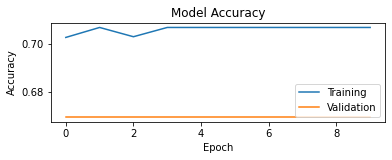

In [20]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# Display Filters

[[[0.38981906]
  [0.57242894]
  [0.40756464]]

 [[0.17761302]
  [0.69788694]
  [0.32190344]]

 [[0.13976064]
  [0.37390897]
  [0.2543837 ]]]


NameError: name 'j' is not defined

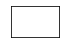

In [27]:
filters, biases = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    print(f)
    
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 6, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
        
# show the figure
plt.show()

We can see from the pictures above what the first 6 filters of the first convolution layer look like. 

# Display feature map

In [28]:
layer_outputs = [layer.output for layer in model.layers]
layer_names = [layer.name for layer in model.layers]

feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

image_path= r"D:\DataSet\CCMD_BreastCancer\Dataset_Clean _Copy\D1-1498_0.jpg"
img = Image.open(image_path).resize((75,75),resample=Image.NEAREST)
img_array = np.asarray(img)

img_array = np.expand_dims(img_array, (-1,0))
input_img = img_array/255.0
print(input_img.shape)

(1, 75, 75, 1)


In [29]:
feature_maps = feature_map_model.predict(input_img)

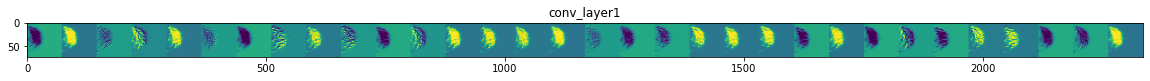

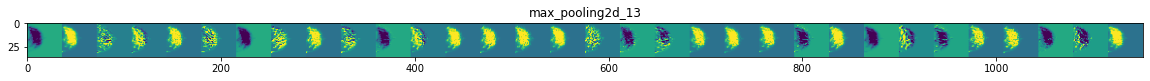

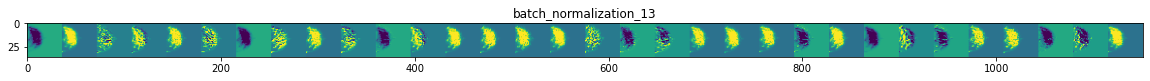

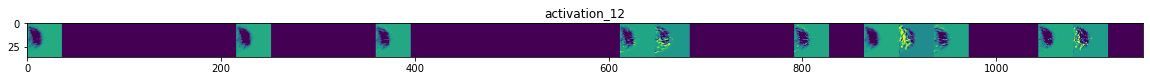

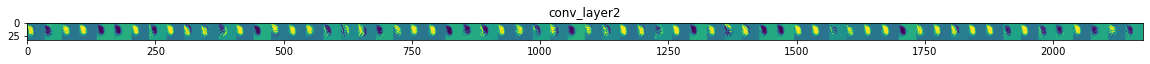

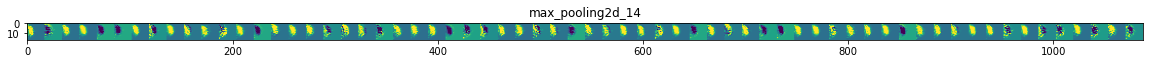

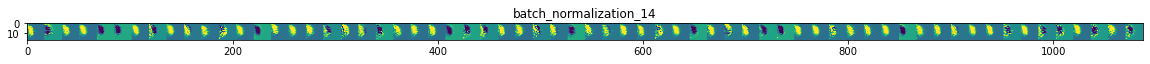

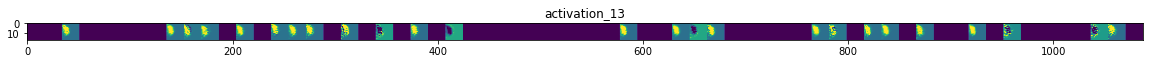

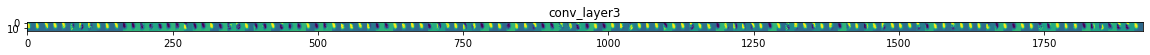

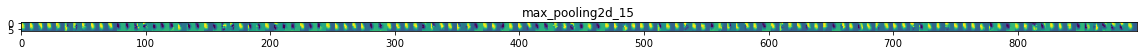

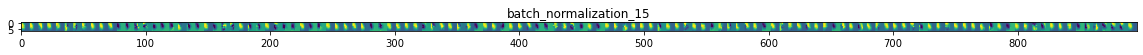

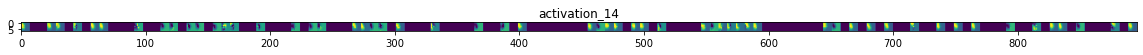

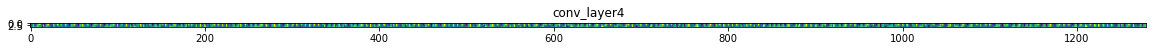

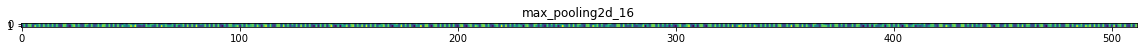

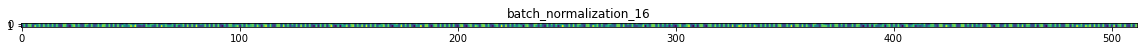

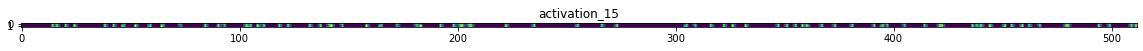

In [31]:
for layer_name, feature_map in zip(layer_names, feature_maps):  
    if len(feature_map.shape) == 4:
        k = feature_map.shape[-1]  
        size = feature_map.shape[1]
        
        display_grid = np.zeros((size, size * k))
        for i in range(k):
            feature_image = feature_map[0, :, :, i]
            feature_image -= feature_image.mean()
            feature_image /= feature_image.std ()
            feature_image *=  64
            feature_image += 128
            feature_image = np.clip(feature_image, 0, 255).astype('uint8')
            
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = feature_image
        
        # Display the grid
        scale = 20. / k
        plt.figure( figsize=(scale * k, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto')

# Test part :

In [27]:
filepath = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean\D1-0021_0.dcm"
img = dicom.dcmread(filepath) #read the dcm file
print(img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital Mammography X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.1239.1759.688928500915688097475664961311
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20170818'
(0008, 0013) Instance Creation Time              TM: '114701'
(000

In [90]:
path_test = "D:\DataSet\CCMD_BreastCancer\Dataset_Clean\D1-0021_0.dcm"

df = pd.read_excel('D:\DataSet\CCMD_BreastCancer\CMMD_clinicaldata_revision.xlsx', index_col=0, engine='openpyxl')
    
print(data_table[18:25])

fileId = 'D1-0021'
side = 'R'

#print((data_table.index == 'D1-0021').sum())

if ((df.index == 'D1-0021').sum()) != 0: #check if the fileId is in the data_table
    # check if there is data for the specific side of the picture
    if (df[(df['LeftRight']=='R') & (df.index=='D1-0021')].index.value_counts().values) != 0:
        print("ok")

        LeftRight  Age  number    abnormality classification subtype
id                                                                  
D1-0019         L   44       2  calcification         Benign     NaN
D1-0020         R   53       2  calcification         Benign     NaN
D1-0021         L   22       2  calcification         Benign     NaN
D1-0021         R   22       2  calcification         Benign     NaN
D1-0022         L   34       2  calcification         Benign     NaN
D1-0023         R   48       2  calcification         Benign     NaN
D1-0024         R   33       2  calcification         Benign     NaN
ok


In [29]:
fileId = 'D1-0021'

if fileId in data_table:
    print("True")